## ovalturk: Oval Turks' Head, 7L x 12B

In Michaelangelo's Piazza del Campidoglio design, he uses a Serlio IV oval pattern with a 5L x 12B Turk's Head pattern, decreasing arithmetically by 1/7 of the radius with each crossing (going inward).


By constrast, here we use a geometric scaling so that each line segment is multiplied by the same factor. This creates a self-similar scaling. If the pattern were circular, the spirals would be logarithmic. But we do a projection of the circular coordinates onto the Serlio-IV oval coordinates.

First, set up matplotlib and other modules.

In [201]:
%matplotlib notebook
import matplotlib
myfmt = "pdf"
%config InlineBackend.figure_formats = {'svg','pdf'}
matplotlib.use(myfmt.upper())
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import *

Vectorized versions of the cosine and sine functions:

In [202]:
vcos = np.vectorize(cos)
vsin = np.vectorize(sin)

Return x and y cartesian coordinate vectors corresponding to polar coordinate r and theta vectors

In [203]:
def xyfromr(theta,r):
    return vcos(theta) * r, vsin(theta) * r

Project from circular position onto Serlio-IV oval. Here we assume y is the long axis and x is the short axis.

In [204]:
# Serlio Oval, form IV
#
# Input cos(theta), sin(theta), output transformed x, y
def serlio_iv(c, s):
    if not hasattr(serlio_iv,"s3"):
        serlio_iv.s3 = sqrt(3)
        serlio_iv.c_corner = cos(atan2(2,serlio_iv.s3))
        serlio_iv.s_corner = sin(atan2(2,serlio_iv.s3))
        
    s3 = serlio_iv.s3
    xbound = serlio_iv.c_corner # s3/2
    ybound = serlio_iv.s_corner # 1./2.
    if c >= xbound:
        # Circle to oval transformation:
        # x = 4*c - s3
        # y = 4*s
        #
        # Circle projected directly to oval:
        # y = s / c * x
        # ((x + s3)/4)^2 + (y/4)^2 = 0
        # ==>
        tantheta = s / c
        a = 1 + tantheta**2
        x = (sqrt(3. + 13. * a) - s3) / a
        y = x * tantheta
    elif s >= ybound:
        # Circle to oval transformation:
        # x = 2*c
        # y = 2*s + 1
        #
        # Circle projected to oval:
        # x = c / s * y
        # ((cotantheta * y)/2)^2 + ((y-1)/2)^2 = 1
        cotantheta = c / s
        a = 1 + cotantheta**2
        y = (1+sqrt(1 + 3 * a))/a
        x = cotantheta * y
    elif c < -xbound:
        # Circle to oval transformation:
        # x = 4*c + s3
        # y = 4*s
        #
        # Cirle projected to oval:
        # y = s / c * x
        # ((x-s3)/4)^2 + (y/4)^2 = 0
        tantheta = s / c
        a = 1 + tantheta**2
        x = (s3 - sqrt(3. + 13. * a)) / a
        y = tantheta * x
    else:
        # Circle to oval transformation:
        # x = 2*c
        # y = 2*s - 1
        #
        # Circle projected to oval:
        # x = c / s * y
        # ((cotantheta * y)/2)^2 + ((y+1)/2)^2 = 1
        cotantheta = c / s
        a = 1 + cotantheta**2
        y = -(1+sqrt(1 + 3 * a))/a
        x = cotantheta * y
    
    # For some reason, matplotlib likes to print out in landscape, so switch the long and short axes to make the oval
    # fit onto a page
    return y, x # x, y

In [205]:
# Vectorized Serlio:
# input radius vector, cosines and sines, output new radius, theta
def vserlio(rr,cc,ss):
    xx = np.zeros(rr.shape)
    yy = np.zeros(rr.shape)
    
    for i, tup in enumerate(zip(cc,ss)):
        c, s = tup
        xx[i], yy[i] = serlio_iv(c,s)
        
    newr  = rr*np.array([sqrt(x*x + y*y) for x, y in zip(xx,yy)])
    theta = np.array([atan2(y,x) for x, y in zip(xx,yy)])

    return newr, theta

In [206]:
def ovalturk(nleads,fmt="svg"):
    
    # rfactor = 1 - (1./nleads) 
    rfactor = (1./3.)**(1./(nleads - 1))
    
    th_sector = pi / 24.
    
    theta = np.arange(361) / 180. * pi
    rc = np.ones([361])

    cc, ss = xyfromr(theta,rc)

    rr,th = vserlio(rc,cc,ss)
    
    # Scale plots
    default_figsize = matplotlib.rcParamsDefault['figure.figsize']
    matplotlib.rcParams['figure.figsize'] = [val*3 for val in default_figsize]
    
    # initialize and clear plot
    plt.ion()
    plt.clf()

    # Polar plot:
    sp = plt.subplot(1, 1, 1, projection='polar')

    # Turn labels off:
    sp.grid(False)
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    
    # Turn border off:
    sp.set_frame_on(False)

    # Plot outer boundary
    plt.plot(th,rr,color='black',linewidth=4)
    plt.plot(th,rr*1.025,color='navy',linewidth=2)
    
    # Plot spirals
    td24 = 360 // 24
    td12 = 360 // 12
    
    rcc = np.array(rc)
    lw = 8
    for j in range(0,nleads,2):
        
        for i in range(td24,361,td12):
            ip1 = i + td24
            ipp = ip1 + 1        
            tdiff = theta[ip1] - theta[i]
            r1 = np.array([rrr * rfactor**((ttt-theta[i])/tdiff) for rrr, ttt in zip(rcc[i:ipp],theta[i:ipp])])
            rr1,th1 = vserlio(r1,cc[i:ipp],ss[i:ipp])
            plt.plot(th1,rr1,color='navy',linewidth=lw)  
        
            im1 = i - td24
            tdiff = theta[im1] - theta[i] 
            imm = im1 # + 2
            r1 = np.array([rrr * rfactor**((ttt-theta[i])/tdiff) for rrr, ttt in zip(rcc[imm:i+1],theta[imm:i+1])])
            rr1,th1 = vserlio(r1,cc[imm:i+1],ss[imm:i+1])
            plt.plot(th1,rr1,color='navy',linewidth=lw)          
            
        
        if (j+2) > nleads:
            break
        
        rcc *= rfactor
        lw *= rfactor
        
        for i in range(0,361,td12):
            ip1 = i + td24
            ill = i
            if (ip1 < 361):
                ipp = ip1 # + 1        
                tdiff = theta[ip1] - theta[i]
                r1 = np.array([rrr * rfactor**((ttt-theta[i])/tdiff) for rrr, ttt in zip(rcc[ill:ipp],theta[ill:ipp])])
                rr1,th1 = vserlio(r1,cc[ill:ipp],ss[ill:ipp])
                plt.plot(th1,rr1,color='navy',linewidth=lw)  
        
            if i > 0:
                im1 = i - td24
                tdiff = theta[im1] - theta[i]
                itt = i # -1
                imm = im1
                r1 = np.array([rrr * rfactor**((ttt-theta[i])/tdiff) for rrr, ttt in zip(rcc[imm:itt],theta[imm:itt])])
                rr1,th1 = vserlio(r1,cc[imm:itt],ss[imm:itt])
                plt.plot(th1,rr1,color='navy',linewidth=lw)          

        rcc *= rfactor
        lw *= rfactor

    rr1 = np.array(rr) * rfactor**nleads * 0.98
    # np.array(rr) / 3
    rr2 = np.array(rr) / 9
    
    # Plot first inner boundary
    # plt.plot(th,rr1,color='navy',linewidth=1)    
    
    # Plot second inner boundary
    plt.plot(th,rr2,color='darkred',linewidth=2)
    
    # Draw triangles from second inner boundary to first inner boundary
    newtheta = th[0:361:td24]
    newrr = rr1[0:361:td24]
    newrr[1::2] = rr2[td24:361:td12]
    plt.plot(newtheta,newrr,color='brown',linewidth=1)
    
    # Adjust boundaries on figure
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)
    plt.savefig("ovalturk_{}Lx12B.{}".format(nleads,fmt), format=fmt)
    plt.show()

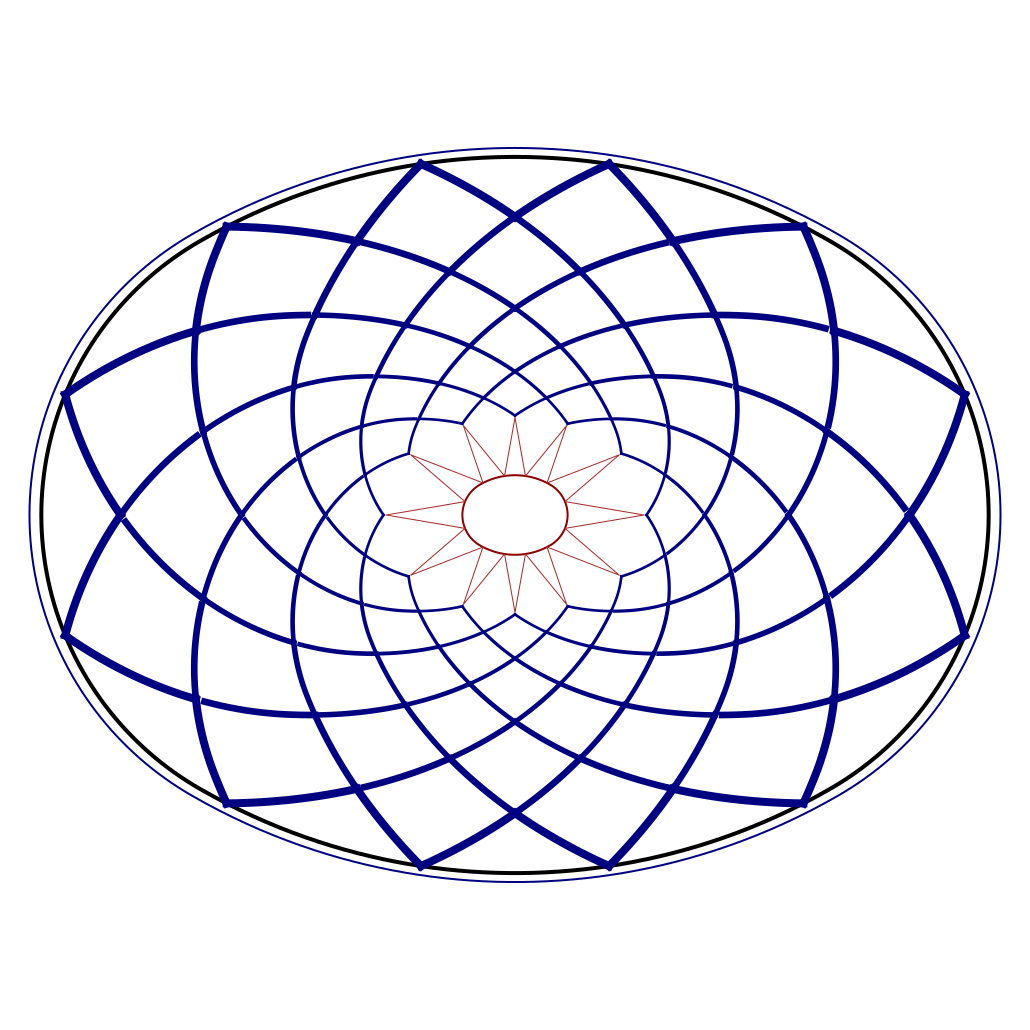

In [207]:
ovalturk(7,fmt=myfmt)